In [1]:
import numpy as np 
import pandas as pd 
import netrd
import pickle
from netrd.reconstruction import PartialCorrelationMatrix
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time
import torch 
import os
import csv

In [2]:
def data_prepare_reg(path):
    with open(path,'rb') as f:
        ds = pickle.load(f)
    data = np.concatenate(ds)
    return data
    

In [3]:
def data_prepare(path):
    with open(path,'rb') as f:
        arr = pickle.load(f)
    num_classes = arr.shape[3]
    if num_classes == 2:
        arr = np.where(arr[:, :, :, 1] == 1.0, 1, 0)
    else:
        arr = np.argmax(arr, axis=-1)
        arr = arr + 1
        
    return arr.reshape(-1, arr.shape[2])
                    
                

In [4]:
def graph_acc(adj,pred_adj):
    t = 0
    for i in range(adj.shape[0]):
        for j in range(adj[i].shape[0]):
            if int(adj[i][j])==pred_adj[i][j]:
                t = t+1
    acc = float(t/(adj.shape[0]*adj.shape[1]))
  
    return acc

def graph_dist(G1, G2):
    a_ij = nx.adjacency_matrix(G1).todense() # graphs have to be symmetric
    b_ij = nx.adjacency_matrix(G2).todense()

    #threshold
    a_ij = (a_ij > 0.0001).astype('float')
    b_ij = (b_ij > 0.0001).astype('float')

    z_ij = a_ij - b_ij
    z_ij = np.abs(z_ij)
    np.fill_diagonal(z_ij, 0.0) # should not need this
    return np.sum(z_ij)/2

def clustering(results,node):
 
    results = np.delete(results,node,0)
    scores = sorted(results)
    scores = np.array(scores)
    cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    cluster.fit(scores.reshape(-1, 1))
    #a = np.count_nonzero(cluster.labels_)
    labels = cluster.labels_
    labels = list(cluster.labels_)
    num_clust1 = list(cluster.labels_).count(labels[0])
    thresh = scores[num_clust1-1]+0.000000000001
    
    labels = (results> thresh).astype('float')
   
    return labels,thresh

def symmetrize(predicted_matrix,scores,node_size,thresholds):

 
    for i in range(predicted_matrix.shape[0]):
        
        for j in range(predicted_matrix[i].shape[0]):
            if predicted_matrix[i][j]!=predicted_matrix[j][i]:
            
                mean_score = (scores[i][j]+scores[j][i])/2
                if mean_score>=(thresholds[i]+thresholds[j])/2:    # (scores[i].mean()+scores[j].mean())/2+0.01:
                    predicted_matrix[i,j]=1
                    predicted_matrix[j,i]=1
                   
                   
                else:
                    predicted_matrix[i,j]=0
                    predicted_matrix[j,i]=0
                    
    return predicted_matrix

def own(Wr,graph,node_size):
    new_wr = []
    thresholds = []
    Wr = np.abs(Wr)
    #Wr = Wr+Wr.T
    for i in range(Wr.shape[0]):
        labels,thresh = clustering(Wr[i],i)
        labels = list(labels)
        labels = np.insert(labels,i,0)
        new_wr.append(labels)
        thresholds.append(thresh)
        
    new_wr = np.array(new_wr)
    new_wr = symmetrize(new_wr,Wr,node_size,thresholds)
    gt = nx.to_numpy_array(graph)
    dist = gt-new_wr
    dist = np.abs(dist)
    dist = np.sum(dist)/2
    return new_wr,dist

def calculate_tpr_fpr(ground_truth, matrix):
    tp = 0
    p = 0
    n = 0
    fp = 0
    for i in range(ground_truth.shape[0]):
        for j in range(ground_truth.shape[1]):
            if i == j:
                continue
            if(ground_truth[i,j] == 0):
                n += 1
                if(matrix[i,j] == 1):
                    fp += 1
            else:
                p += 1
                if(matrix[i,j] == 1):
                    tp += 1
    return (tp / p, fp / n)

def chec_spec_baseline(data, method):
    methods = {'corr':netrd.reconstruction.CorrelationMatrix(),
              'par_corr':netrd.reconstruction.PartialCorrelationMatrix(),
              'mi':netrd.reconstruction.MutualInformationMatrix(),
              'granger':netrd.reconstruction.GrangerCausality()}
    start = time.time()
    recon = methods[method]
    #recon = netrd.reconstruction.CorrelationMatrix()
    TS = data.T
    avg_k = 5
   # start_time = time.time() 
    if recon=='mi':
        G_pred = recon.fit(TS,threshold_type='degree', avg_k = avg_k)
    else:
        G_pred = recon.fit(TS,threshold_type='degree', avg_k = avg_k)
    W = recon.results['weights_matrix']
    finish = time.time()
    run_time = finish-start
    return np.abs(W),run_time

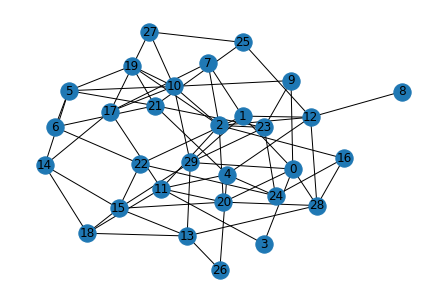

In [5]:
G_erdos_small = nx.erdos_renyi_graph(30, 0.15, seed=43,directed = False)
G_erdos_small = nx.convert_node_labels_to_integers(G_erdos_small)
nx.draw(G_erdos_small, with_labels=True, pos=nx.kamada_kawai_layout(G_erdos_small))

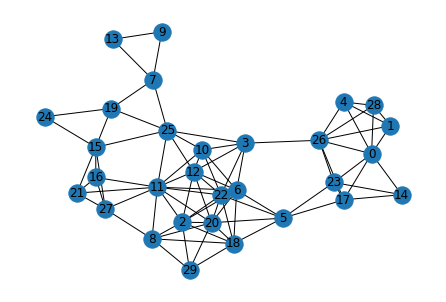

In [6]:
G_geom_small = nx.random_geometric_graph(30, 0.3, seed=43)
G_geom_small = nx.convert_node_labels_to_integers(G_geom_small)
nx.draw(G_geom_small, with_labels=True, pos=nx.kamada_kawai_layout(G_geom_small))

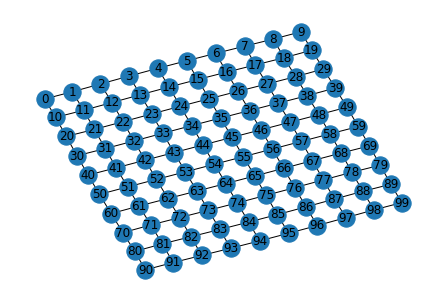

In [7]:
g = nx.grid_2d_graph(10,10)
g = nx.convert_node_labels_to_integers(g)
nx.draw(g, with_labels=True, pos=nx.kamada_kawai_layout(g))

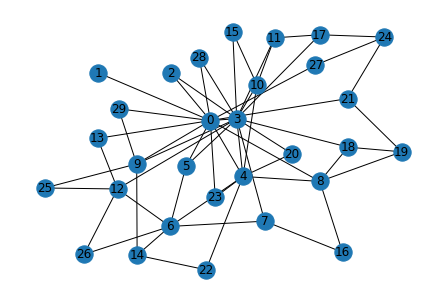

In [8]:
NUM_NODES = 30
albert = nx.barabasi_albert_graph(NUM_NODES, 2, seed=0)
#g = nx.bull_graph()
nx.draw(albert, with_labels=True, pos=nx.spring_layout(albert, seed=43))

In [10]:


path_4 = ['datasets/sis/hetro_sis_albert.pickle',
         'hetro_sis_erdos.pickle',
         'datasets/cml/hetro_cml_albert.pickle',
         'cml/hetro_cml_erdos.pickle']


In [11]:
def create_results_data(data,name):
    header = ['Experiment Name','Graph','Node Size','Edge Size','Dynamics','Method','Acc','TP','FP','loss','Run Time']
    if not os.path.exists(name):
        with open(name, 'a') as f_object:
            writer_object = csv.writer(f_object)
 
            writer_object.writerow(header)
 
            writer_object.writerow(data)
 
            # Close the file object
            f_object.close()
    else:
        with open(name, 'a') as f_object:
            writer_object = csv.writer(f_object)
 
 
            writer_object.writerow(data)
 
           # Close the file object
            f_object.close()
            

In [13]:
def all_together(path,graph,experiment,g,dynamics,name,problem,r):
    num_nodes = graph.number_of_nodes()
    if dynamics == 'cml':
        data = data_prepare_reg(path)
    else:
        data = data_prepare(path)
    
    methods = ['corr','mi','par_corr']
    results = {}
    for i in methods:
        start = time.time()
        Weights,run_time = chec_spec_baseline(data,i)
        new_wr,dist = own(Weights,graph,num_nodes)
        finish = time.time()
        run_time = finish-start
        adj = nx.to_numpy_array(graph)
        acc = round(graph_acc(adj,new_wr),2)
        tp,fp = calculate_tpr_fpr(adj,new_wr)
        result = {'acc':acc,'tp':tp,'fp':fp,'loss':dist,'time':run_time}
        edge = graph.number_of_edges()
        df = [experiment,g,num_nodes,edge,dynamics+str(r),i,acc,tp,fp,round(dist,2),run_time]
        create_results_data(df,name)
        results[i]=result
        
  
    return results,Weights

In [15]:
dyn = ['sis','sis','cml','cml']
#for i in range(len(path_1)):
    #results = all_together(path_1[i],G_erdos_small,100,'erdos_100_'+dyn[i],'erdos',dyn[i],'baselines.csv','class')
    
#for i in range(len(path_2)):
    #results = all_together(path_2[i],G_geom_small,100,'geom_100_'+dyn[i],'geom',dyn[i],'baselines.csv','class')

#for i in range(len(path_3)):
    #results = all_together(path_3[i],g,100,'grid_100_'+dyn[i],'grid',dyn[i],'baselines.csv','class')
graphs_str = ['albert','erdos','albert','erdos']
graphs = [albert,G_erdos_small,albert,G_erdos_small]
r = ['hetro','hetro','hetro','hetro']
weights = {}

for i in range(len(path_4)):
    results,w = all_together(path_4[i],graphs[i],'baselines',graphs_str[i],dyn[i],'baselines_hetro.csv','reg',r[i])
    weights[str(i)]=w
    
#for i in range(len(path_5)):
    #results = all_together(path_5[i],graphs[i],100,graphs_str[i]+'_100_'+dyn[1],graphs_str[i],dyn[1],'baselines.csv','reg')